In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy                  # http://scipy.org/
from scipy import signal
from numpy import pi

from IPython.display import Image  

from scipy.fftpack import fft, fftfreq
from time import time

%matplotlib inline
params = {'legend.fontsize': 16,
          'figure.figsize': (10, 8),
         'axes.labelsize': 16,
         'axes.titlesize': 16,
         'xtick.labelsize':16,
         'ytick.labelsize':16}
plt.rcParams.update(params) 


In [28]:
print(2e6/12800)



156.25


## Parameters

For an ASIC, $N_{det} = 128 $, channels are multiplexed temporally.
It is supposed that the observation of a detector lasts $T_{MUX} = 1/f_{MUX}$, and that after this time, one passes from the detector n to the n+1.
During a $T_{MUX}$ period, sampling at the frequency $f_{sam}$ makes it possible to obtain $N_{sam}$ samples of the detectors n less raw signals $R^{n}_{i} $with $N_{sam} fb^{n} f_{sam}/f_{MUX} =  100  $.

The scientific signal is obtained by averaging these samples, possibly with a mask $m_{i}$ equal to 0 or 1:

$$ S^{n}(k) = \frac{ \sum_{i=1}^{N_{sam}} m_{i} R_{i}^{n}  }{1}  $$

## PID

In order to ensure the SQUID flow-lock feedback loop, a PID-type algorithm must be in place keeping the previous operating point in memory.
The parameters of this algorithm - P, I and T - are supposed to be constant (independent of the detector) but adjustable in real time (positive in negative).


For each detector, this requires the calculation of the feedback signal $fb^{n}$ to be applied in a constant manner during the observation period $T_{MUX}$ of the detector n.
The equation of this signal is the following:

$$ fb^{n} = P \times \varepsilon^{n}(k-1) + I \times \sum_{j=1}^{k-1} \varepsilon^{n}(j) + D \times [ \varepsilon^{n}(k-1)-\varepsilon^{n}(k-2)] $$

where $ \varepsilon^{n}(j) = S^{n}(k)- C^{n}$ with $C^{n}$ is the setpoint for the n detector (adjustable).



Attention to the possible saturation of the integral term.

The implementation can be done recursively if necessary:

$$ fb^{n} = fb^{n}(k-1) + P \times [\varepsilon^{n}(k-1) - \varepsilon^{n}(k-2)]+ I \times \varepsilon^{n}(k-1) + D \times [ 2 \varepsilon^{n}(k-2) - \varepsilon^{n}(k-1)-\varepsilon^{n}(k-3)] $$

What is also written:

$$ fb^{n} = fb^{n}(k-1) + P \times [S^{n}(k-1) - S^{n}(k-2)]+ I \times [S^{n}(k-1) - C^{n} ] + D \times [ 2 S^{n}(k-2) - S^{n}(k-1)-S^{n}(k-3)] $$











### Serie de Fourier trigonometrica

Luego la serie de Fourier asociada a $f(t)\,$ es:

$$f(t) \sim \frac{a_0}{2} + \sum_{n=1}^\infty\left[a_n\cos \left( \frac{2n\pi}{T}t \right) + b_n\sin \left( \frac{2n\pi}{T}t \right) \right]$$

Donde $a_0$, $a_n$ y $b_n$ son los coeficientes de la serie de Fourier que toman los valores:

$$ a_0 = \frac{2}{T} \int_{-\frac{T}{2}}^{\frac{T}{2}}  f(t) dt $$

$$ a_n = \frac{2}{T} \int_{-T/2}^{T/2}  f(t) \cos \left( \frac{2n \pi}{T} t \right) dt$$

$$ b_n = \frac{2}{T} \int_{-T/2}^{T/2}  f(t) \sin \left(\frac{2n\pi}{T}t\right) dt$$


### Serie de Fourier exponencial
Por la identidad de Euler, las fórmulas de arriba pueden expresarse también en su forma compleja:

$$ f(t) \sim \sum_{n=-\infty}^{\infty} c_{n}\,e^{2\pi i\frac{n}{T}t}.$$

Los coeficientes ahora serían:

$$c_n=\frac{1}{T}\int_{-T/2}^{T/2} f(t)\,e^{-2\pi i\frac {n}{T}t}\,dt.$$

Otra forma de definir la serie de Fourier es:

$$f(t) = \frac{a_0}{2} + \sum_{n=1}^\infty\left(a_n\cos{{\omega_n}{t}} + b_n\sin{{\omega_n}{t}}\right)$$

donde
$\omega_n=n\omega$
y
$\omega=2{\pi}f=\frac{2{\pi}}{T}$

siendo:

$$ a_0 = \frac{2}{T} \int_{t_0}^{t_0+T}  f(t) dt$$

$$ a_n = \frac{2}{T} \int_{t_0}^{t_0+T}  f(t) \cos{{\omega_n}{t}} dt$$ 

$$ b_n=\frac{2}{T} \int_{t_0}^{t_0+T} f(t) \sin {{\omega_n}{t}} dt$$



### Euler's formula:
$$ e^{ i \theta} = cos(\theta) + i \cdot sin(\theta)$$




### Serie de Fourier exponencial discreta

Sea x(n) una señal aperiódica discreta en el tiempo, la transformada discreta de Fourier (DFT) de esta señal se define como:

$$X[k]= \sum_{n=0}^{N-1} x[n]\,e^{-j 2\pi n \frac{k}{N}}$$

en la cual X(k) es un conjunto de números complejos. 

La evaluación directa de esa fórmula requiere $N^{2}$ operaciones aritméticas, pero con un algoritmo FFT se puede obtener el mismo resultado con sólo $N log N$ operaciones.


$$x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k]\cdot e^{i 2 \pi k \frac{n}{N}}$$

In [4]:
# Estas funciones calculas las componentes de la serie de Fourier para una senal dada
# A cada función se pasa como argumento la señal x y el numero de armonico a calcular.
# El muestreo se define por la cantidad de muestras dentro del periodo de la señal x.


# Transformada Discreta de Fourier     
def DFT(x):
    N = len(x)
    print(N)
    X = list()
    for k in range(N):
        X.append( sum([s*np.exp(-2j*np.pi*n*k/N) for n,s in enumerate(x)]))
    return np.array(X)  
    


# Transformada Inversa Discreta de Fourier       
def IDFT(X):
    N = len(X)
    x = list()
    for n in range(N):
        x.append( sum([S*np.exp(2j*np.pi*k*n/N) for k,S in enumerate(X)]))
    return np.array(x)/N  



    
def freq(X, fs):
    N =  len(X)
    fo = np.arange(0,N/2,1) *fs/ N
    fo = np.append(fo,np.arange(-N/2,0,1) *fs/N )
    return fo

def tim(x, fs):
    return np.arange(0,len(x),1) /fs
    

### A continuación se define la función de la señal en función del tiempo. 

In [22]:
# Parametros de la señal
f  = 158.25     # Hz
fs = 2e5     # muestreo
dt = 1 / (fs)  # Espaciado (puntos por período)
N  = fs / f

# Vector tiempo
# np.linspace( inicio, fin, paso)
t  = np.linspace(0, (N - 1) * dt, N)  # Intervalo de tiempo en segundos 


# Señal
y =    signal.square(2 * np.pi * f * t, duty= 0.1)




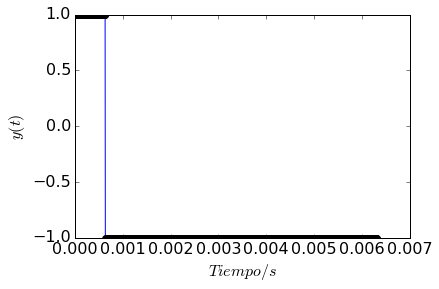

In [23]:
## PLOT 
plt.plot(t, y)
plt.plot(t, y, 'ko')
plt.xlabel('$Tiempo/s$')
plt.ylabel('$y(t)$')
plt.show()

## Calculo del espectro empleando la funciones de scipy.fftpack  (fft, fftfreq)

Se emplea mide el tiempo de computo de la función con fines de comparación. 

Elapsed time: 0.0009069443 seconds.


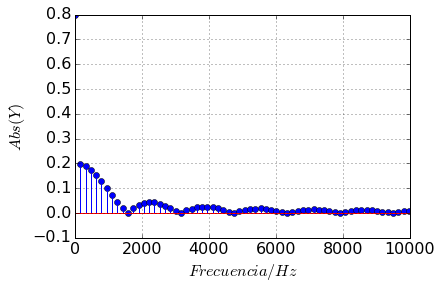

In [26]:
# se guarda el tiempo de inicio 
start_time = time()
 
Y = fft(y) / len(y)  # Normalizada

elapsed_time = time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)

frq = fftfreq(len(y), dt)  # Recuperamos las frecuencias

plt.stem(frq, np.abs(Y) )  # Representamos la parte imaginaria
plt.ylim(-0.1, 0.8)
plt.xlim( 0, 1e4)
plt.xlabel('$Frecuencia/Hz$')
plt.ylabel('$Abs(Y)$')
plt.grid()
plt.show()

## Cálculo del espectro empleando la funciones propias.

Se mide el tiempo de computo de la función con fines de comparación. 

In [12]:
# Serie de Fourier Exponencial
# la separacion de las deltas = 1/T 

start_time = time()

Y    = DFT(y) / len(y)

elapsed_time = time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)



plt.stem( freq(y,fs) , np.abs(Y))
plt.ylabel('c')
plt.xlabel('freq')
plt.ylim(-0.1, 0.8)
plt.grid()
plt.show()


12800


KeyboardInterrupt: 

/home/aalmela/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


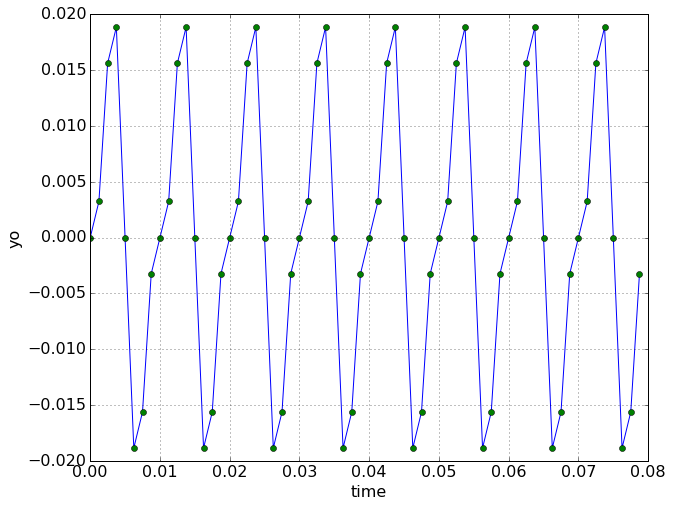

In [15]:
yo    = IDFT(Y)


plt.plot(tim(yo,fs), yo)
plt.plot(tim(yo,fs), yo,'o')

plt.ylabel('yo')
plt.xlabel('time')

plt.grid()
plt.show()


## Spectral leakage

Cuando se calcula la transformada discreta de Fourier (DFT) de una señal (por ejemplo, para obtener la densidad espectral de potencia), el manchado espectral o leakage ocurrirá si alguna de las componentes frecuenciales cae entre frecuencias de referencia.

El leakage también tiene lugar cuando se calcula la DFT de una señal que contiene el resto de un ciclo. Por ejemplo, si una onda senoidal de 3 Hz se muestrea durante 0.9 segundos, se produce una discontinuidad, la cual causa un manchado espectral. 


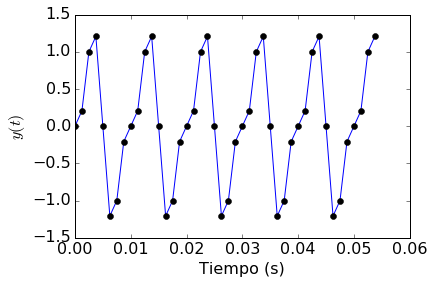

Elapsed time: 0.0626933575 seconds.


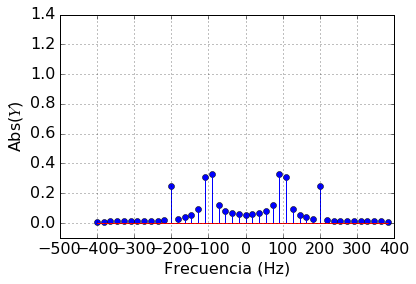

In [9]:
N2  = 44        # Número de bines
f  = 100.0     # Hz
fs = f * 8     # muestreo
dt = 1 / (fs)  # Espaciado (puntos por período)

# np.linspace( inicio, fin, paso)
t2  = np.linspace(0, (N2 - 1) * dt, N2)  # Intervalo de tiempo en segundos 

y2 = np.sin(2 * pi * f * t2) - 0.5 * np.sin(2 * pi * 2 * f * t2)  # Señal

plt.plot(t2, y2)
plt.plot(t2, y2, 'ko')
plt.xlabel('Tiempo (s)')
plt.ylabel('$y(t)$')
plt.show()

start_time = time()
Y2 = fft(y2) / N2  # Normalizada

elapsed_time = time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)

frq2 = fftfreq(N2, dt)  # Recuperamos las frecuencias

plt.stem(frq2, np.abs(Y2) )  # Representamos la parte imaginaria
plt.ylim(-0.1, 1.4)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Abs($Y$)')
plt.grid()
plt.show()

## Zero Padding


Zero padding es una tecnica empleada con el objetivo de tener ventanas con numeros de bines multiplos de 2. Para ello se agregan ceros al final de la muestra.

48


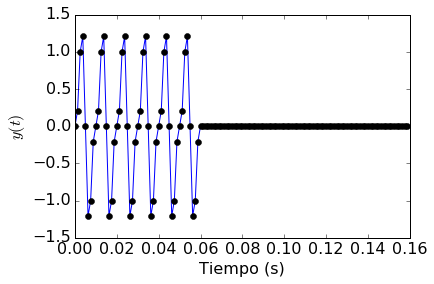

Elapsed time: 0.0002646446 seconds.


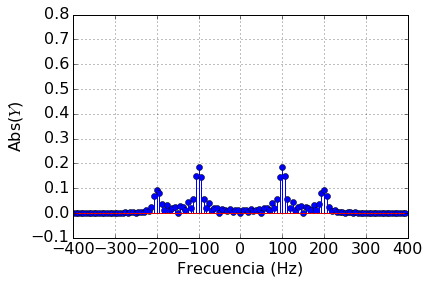

In [10]:
N3 = 128         # Número de bines
Nz = 80
f  = 100.0     # Hz
fs = f * 8     # muestreo
dt = 1 / (fs)  # Espaciado (puntos por período)

# np.linspace( inicio, fin, paso)
t3  = np.linspace(0, (N3 - 1) * dt, N3)  # Intervalo de tiempo en segundos 

y3 = np.sin(2 * pi * f * t3[:-Nz]) - 0.5 * np.sin(2 * pi * 2 * f * t3[:-Nz])  # Señal
print(len(y3))
y3 =  np.append(y3,np.zeros(Nz) )


plt.plot(t3, y3)
plt.plot(t3, y3, 'ko')
plt.xlabel('Tiempo (s)')
plt.ylabel('$y(t)$')
plt.show()

start_time = time()
Y3 = fft(y3) / N3  # Normalizada

elapsed_time = time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)

frq3 = fftfreq(N3, dt)  # Recuperamos las frecuencias

plt.stem(frq3, np.abs(Y3) )  # Representamos la parte imaginaria
plt.ylim(-0.1, 0.8)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Abs($Y$)')
plt.grid()
plt.show()

## Ventanas 

Existe una manera de reducir la fuga y es mediante el uso de funciones ventana. Las funciones ventana no son más que funciones que valen cero fuera de un cierto intervalo, y que en procesamiento de señales digitales se utilizan para «suavizar» o filtrar una determinada señal. NumPy trae unas cuantas funciones ventana por defecto; por ejemplo, la ventana de Blackman tiene este aspecto


Como se puede ver, en los extremos del intervalo es nula. Las funciones ventana reciben un único argumento que es el número de puntos. Si multiplicamos la ventana por la señal, obtenemos una nueva señal que vale cero en los extremos. Comprobemos el resultado, representando ahora el espectro de amplitud y comparando cómo es el resultado si aplicamos o no la ventana de Blackman.

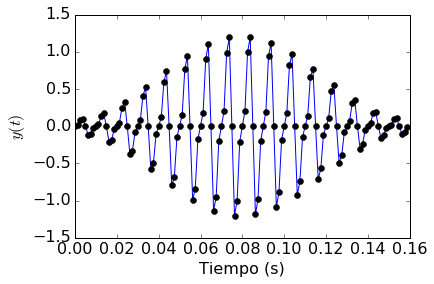

Elapsed time: 0.0002548695 seconds.


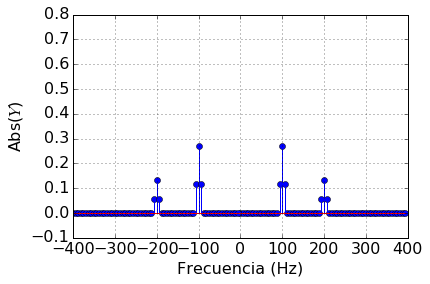

In [11]:
M = 128         # Número de bines

f  = 100.0     # Hz
fs = f * 8     # muestreo
dt = 1 / (fs)  # Espaciado (puntos por período)

# np.linspace( inicio, fin, paso)
t4  = np.linspace(0, (M - 1) * dt, M)  # Intervalo de tiempo en segundos 

y4 = np.sin(2 * pi * f * t4) - 0.5 * np.sin(2 * pi * 2 * f * t4)  # Señal


#y4 = y4 * np.bartlett(M)
#y4 = y4 * np.blackman(M) 
y4 = y4 * np.hamming(M) 
#y4 = y4 * np.hanning(M) 
#y4 = y4 * np.kaiser(M, 10) 



plt.plot(t4, y4)
plt.plot(t4, y4, 'ko')
plt.xlabel('Tiempo (s)')
plt.ylabel('$y(t)$')
plt.show()

start_time = time()
Y4 = fft(y4) / M  # Normalizada

elapsed_time = time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)

frq4 = fftfreq(M, dt)  # Recuperamos las frecuencias

plt.stem(frq4, np.abs(Y4) )  # Representamos la parte imaginaria
plt.ylim(-0.1, .8)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Abs($Y$)')
plt.grid()
plt.show()